In [1]:
# Load the Pandas libraries with alias 'pd'
import pandas as pd
from shapely.geometry import LineString, MultiLineString
from sklearn.cluster import KMeans
from bokeh.tile_providers import CARTODBPOSITRON
# Read data from file 'filename.csv'
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
import geopandas as gpd
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource, Range1d
#import pysal as ps
import seaborn as sns
import numpy as np
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from bokeh.palettes import RdYlBu11 as palette
from bokeh.models import LogColorMapper

In [2]:
# File paths Example
roads_Afr = r"data/roads/CAR_DATA_140731_Roads.shp"
grid_Afr = r"data/caf_admbnda_adm1_200k_sigcaf_reach_itos_v2.shx"

In [3]:
print(grid_Afr)
print(roads_Afr)

data/caf_admbnda_adm1_200k_sigcaf_reach_itos_v2.shx
data/roads/CAR_DATA_140731_Roads.shp


In [4]:
roads_Afr = gpd.read_file(roads_Afr)
grid_Afr = gpd.read_file(grid_Afr)
print(grid_Afr['geometry'])
print(grid_Afr['geometry'].shape)

0     POLYGON ((17.08247 5.02498, 17.10072 5.02106, ...
1     POLYGON ((16.87055 4.07722, 16.87638 4.06972, ...
2     POLYGON ((16.78861 5.34666, 16.81638 5.34638, ...
3     POLYGON ((15.18888 6.71721, 15.18722 6.71028, ...
4     POLYGON ((19.07528 8.52805, 19.07639 8.52250, ...
5     POLYGON ((19.14527 6.43722, 19.16305 6.43333, ...
6     POLYGON ((19.09833 8.51722, 19.09694 8.51166, ...
7     POLYGON ((16.59444 7.86206, 16.58680 7.85154, ...
8     POLYGON ((22.52068 11.00756, 22.55266 10.99373...
9     POLYGON ((21.47833 9.76916, 21.48472 9.76833, ...
10    POLYGON ((23.50040 8.96242, 23.50361 8.96192, ...
11    POLYGON ((24.43936 8.27588, 24.46172 8.27271, ...
12    POLYGON ((24.59694 6.38333, 24.60361 6.38305, ...
13    POLYGON ((17.98750 5.85138, 17.99305 5.85055, ...
14    POLYGON ((21.40916 7.34222, 21.40999 7.32889, ...
15    POLYGON ((21.44471 5.69111, 21.45083 5.68722, ...
16    POLYGON ((18.55253 4.42947, 18.55340 4.42931, ...
Name: geometry, dtype: geometry
(17,)


In [5]:
#CrsA=gridsAf.crs
#print(CrsA)

In [6]:
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""

    # Parse the exterior of the coordinate
    exterior = row[geom].exterior

    if coord_type == 'x':
        # Get the x coordinates of the exterior
        return list( exterior.coords.xy[0])
    elif coord_type == 'y':
        # Get the y coordinates of the exterior
        return list( exterior.coords.xy[1])

def getLineCoords(row, geom, coord_type):
    """Returns a list of coordinates ('x' or 'y') of a LineString geometry"""
    if isinstance(row[geom], MultiLineString):
        empty_l = []
        return empty_l
    else:
        if coord_type == 'x':
            return list( row[geom].coords.xy[0])
        elif coord_type == 'y':
            return list( row[geom].coords.xy[1])

def getPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

In [7]:
# Get the Polygon x and y coordinates
grid_Afr['x'] = grid_Afr.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
print("This is ground Africa x:{0}".format(grid_Afr['x']))
print(grid_Afr)
print(grid_Afr['x'].shape)
grid_Afr['y'] = grid_Afr.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)
print("This is ground Africa y{0}:".format(grid_Afr['y']))
print("This is shape of Africa y{0}:".format(grid_Afr['y'].shape))
# Calculate x coordinates of the line
roads_Afr['x'] = roads_Afr.apply(getLineCoords, geom='geometry', coord_type='x', axis=1)
print(roads_Afr['x'])
print(roads_Afr['x'].shape)
# Calculate y coordinates of the line
roads_Afr['y'] = roads_Afr.apply(getLineCoords, geom='geometry', coord_type='y', axis=1)
print(roads_Afr['y'])
print(roads_Afr['y'].shape)

This is ground Africa x:0     [17.082470000000058, 17.100720000000024, 17.11...
1     [16.870548000000042, 16.876383000000033, 16.88...
2     [16.788606000000073, 16.816381000000035, 16.83...
3     [15.188883000000033, 15.187216000000035, 15.18...
4     [19.07527600000003, 19.07638600000007, 19.0747...
5     [19.14526900000004, 19.163051000000053, 19.181...
6     [19.098328000000038, 19.096937000000025, 19.09...
7     [16.59444300000007, 16.586795000000052, 16.585...
8     [22.52067500000004, 22.55265600000007, 22.5609...
9     [21.478327000000036, 21.484718000000044, 21.49...
10    [23.500396000000023, 23.503606000000048, 23.51...
11    [24.43936300000007, 24.461718000000076, 24.475...
12    [24.596944000000065, 24.60361000000006, 24.609...
13    [17.987500000000068, 17.99305300000003, 17.998...
14    [21.409158000000048, 21.409993000000043, 21.41...
15    [21.444714000000033, 21.45082700000006, 21.454...
16    [18.55253175400003, 18.55340426300006, 18.5539...
Name: x, dtype: object
 

0       [6.2301338682834775, 6.232933868803098, 6.2359...
1       [6.013448606566424, 6.010333868413337, 6.00973...
2       [6.391333868263555, 6.375333868763139, 6.36513...
3       [6.430396409666667, 6.415933868653173, 6.40223...
4       [6.262833868088652, 6.25893386900302, 6.254133...
                              ...                        
1963    [8.867333868063149, 8.854333868413228, 8.85023...
1964    [10.08086600000006, 10.088820000000037, 10.088...
1965    [9.001649788257765, 9.003133867634755, 9.00533...
1966    [5.817289448885926, 5.8173642001977335, 5.8226...
1967    [5.042287521713346, 5.041841446000149, 5.05479...
Name: y, Length: 1968, dtype: object
(1968,)


In [8]:
m_df = roads_Afr.drop('geometry', axis=1).copy()
g_df = grid_Afr.drop('geometry', axis=1).copy()

In [9]:
# Create the color mapper
color_mapper = LogColorMapper(palette=palette)
# Point DataSource
msource = ColumnDataSource(m_df)
gsource = ColumnDataSource(g_df)
# Initialize our plot figure
p = figure(title="Road Network of Central Africa")
# Plot grid
name="roads of Central Africa"
p.patches('x', 'y', source=gsource,
         fill_color={'field': 'Shape_Leng', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.05)

p.multi_line('x', 'y', source=msource, color='red', line_width=3, legend_label=name)
p.legend.location = "top_left"
p.legend.click_policy="mute"
# Output filepath
outfp = "data/test.html"

# Save the map
output_file(outfp)
show(p)


In [10]:
colorize=[]
labelsrg=[]
X = np.array(m_df['DIST_KM'])
thres = np.mean(X)
print(m_df['DIST_KM'])
for i in range(0,1936):
    if m_df['DIST_KM'][i]<=thres:
        colora="#ADD8E6"
        labelreg='Cheap Distance'
    else:
        colora='#CFEC14'
        labelreg='Expensive Distance'
    colorize.append(colora)
    labelsrg.append(labelreg)
print(colorize)

0       20.513612
1        1.649995
2       75.953788
3       38.101928
4       50.292963
          ...    
1963    92.776229
1964    29.491232
1965    78.161475
1966    10.852312
1967    31.499193
Name: DIST_KM, Length: 1968, dtype: float64


['#CFEC14', '#ADD8E6', '#CFEC14', '#CFEC14', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#CFEC14', '#ADD8E6', '#ADD8E6', '#CFEC14', '#CFEC14', '#ADD8E6', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#CFEC14', '#ADD8E6', '#ADD8E6', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#CFEC14', '#ADD8E6', '#CFEC14', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#CFEC14', '#CFEC14', '#ADD8E6', '#ADD8E6', '#CFEC14', '#CFEC14', '#ADD8E6', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#ADD8E6', '#ADD8E6', '#CFEC14', '#CFEC14', '#ADD8E6', '#ADD8E6', '#CFEC14', '#CFEC14', '#CFEC14', '#ADD8E6', '#CFEC14', '#CFEC14', '#CFEC14', '#ADD8E6', '#CFEC14', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#ADD8E6', '#CFEC14', '#ADD8E6', '#ADD8E6', '#ADD8E6', '#CFEC14', '#ADD8E6', '#CFEC14', '#CFEC14', '#CFEC14'

1968
0.10288313887566941


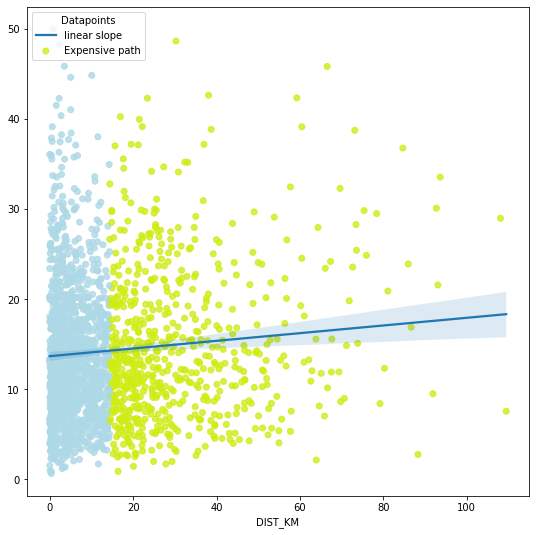

In [11]:
#using the distance as a feature
import libpysal
import esda
import numpy as np
import seaborn as sns
print(len(m_df['DIST_KM']))
lista = m_df['DIST_KM'][:1936]
w = libpysal.weights.lat2W(44,44)
w.transform = "R"
y1 = libpysal.weights.lag_spatial(w,lista)
spatial_auto = esda.Moran(y1, w)
print(spatial_auto.I)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=lista, y=y1, data=lista, scatter_kws={'color':colorize}, label=labelsrg)
plt.legend(title='Datapoints', loc='upper left', labels=['linear slope', 'Expensive path'])
# Display
plt.show()

In [12]:
X = np.array(m_df['DIST_KM'])
thres = np.mean(X)
thresm = X[3]
labels=[]
for i in X:
    if i > thres:
        lab='green'
    else:
        lab='blue'
    labels.append(lab)
print(len(labels))
print(X)
X = X.reshape(-1,1)
print(len(X))
X_train, X_test, y_train,y_test = train_test_split(X,labels,test_size=0.25)
nbrs =neighbors.KNeighborsClassifier(n_neighbors=13, weights='uniform',algorithm='auto').fit(X_train, y_train)
prediction =nbrs.predict(X_test)
print(prediction)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
prediction = np.array(prediction)
X_train = X_train.reshape(len(X_train),1)
X_test = X_test.reshape(len(X_test),1)
y_train = y_train.reshape(len(y_train),1)
prediction = prediction.reshape(len(prediction),1)
TrainRoad=np.hstack((X_train,y_train))
TestRoad = np.hstack((X_test,prediction))
Ds = np.vstack((TrainRoad,TestRoad))
names=[]
for i in Ds[:,1]:
    if i=='blue':
        name='Cheap path'
    else:
        name='Expensive path'
    names.append(name)
print(names)
print(Ds[:,1])
# Creating a dataframe object from listoftuples
m_df['name'] = pd.DataFrame(names)
m_df['KM_LTM']= pd.DataFrame(data = Ds[:,1], columns=['KM'])
m_df['DIST_KM']= pd.DataFrame(data= Ds[:,0], columns=['DIST_KM'])

1968
[20.51361151  1.64999524 75.95378771 ... 78.16147545 10.85231192
 31.49919258]
1968
['blue' 'blue' 'blue' 'blue' 'blue' 'green' 'blue' 'blue' 'blue' 'blue'
 'green' 'green' 'green' 'blue' 'blue' 'green' 'blue' 'blue' 'blue'
 'green' 'blue' 'blue' 'green' 'green' 'green' 'green' 'blue' 'blue'
 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'green'
 'green' 'blue' 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'green' 'blue'
 'green' 'blue' 'blue' 'green' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue'
 'blue' 'green' 'green' 'blue' 'blue' 'blue' 'blue' 'green' 'blue' 'blue'
 'green' 'blue' 'blue' 'blue' 'blue' 'green' 'blue' 'blue' 'blue' 'blue'
 'blue' 'blue' 'green' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'green'
 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'green' 'blue'
 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'green' 'blue'
 'blue' 'green' 'blue' 'blue' 'blue' 'blue' 'blue' 'green' 'green' 'blue'
 'blue' 'blue' 'green' 'blue' 'blue' 'blue' 

In [13]:
# Point DataSource
# Create the color mapper
color_mapper = LogColorMapper(palette=palette)
msource2 = ColumnDataSource(m_df)
gsource2 = ColumnDataSource(g_df)
# Initialize our plot figure
f = figure(title="Road Network of Central Africa")
# Plot grid
f.patches('x', 'y', source=gsource2,
         fill_color={'field': 'Shape_Leng', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.05)

f.multi_line('x', 'y', source=msource2,
             line_color='KM_LTM',
             line_alpha=0.5, line_width=3, legend_group='name')
# Output filepath
p.legend.location = "top_left"
p.legend.click_policy="mute"
outff = "data/tesd.html"
# Save the map
output_file(outff)
show(f)

In [14]:
#health building prediction
A_pi = r"data/southAfrica/healthsites.shp"
A_ro = r"data/southAfricaTwo/Mon_Lines.shp"
A_gi = r"data/southAfricaTwo/Mon_Areas.shp"
A_p = gpd.read_file(A_pi)
A_r = gpd.read_file(A_ro)
A_g = gpd.read_file(A_gi)
print(A_g)
#A_p['geometry'] = A_p['geometry'].to_crs(crs=CRS)
# Calculate x coordinates of the Point
A_p['x'] = A_p.apply(getPointCoords, geom='geometry', coord_type='x', axis=1)
# Calculate y coordinates of the Point
A_p['y'] = A_p.apply(getPointCoords, geom='geometry', coord_type='y', axis=1)
# Calculate x coordinates of the line
A_r['x'] = A_r.apply(getLineCoords, geom='geometry', coord_type='x', axis=1)
# Calculate y coordinates of the Point
A_r['y'] = A_r.apply(getLineCoords, geom='geometry', coord_type='y', axis=1)
# Calculate x coordinates of the Poly
A_g['x'] = A_g.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
# Calculate y coordinates of the Point
A_g['y'] = A_g.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)
p_df = A_p.drop('geometry', axis=1).copy()
r_df = A_r.drop('geometry', axis=1).copy()
g_df = A_g.drop('geometry', axis=1).copy()
datapoints = p_df['healthcare']
d_n=[]
colors=[]
namesl=[]
for i in range(len(datapoints)):
    if datapoints[i]=='hospital':
        value=1
        color='red'
        namesla='hospital'
    elif datapoints[i]=='clinic':
        value=2
        color='blue'
        namesla='clinic'
    elif datapoints[i]=='dentist':
        value=3
        color='orange'
        namesla='dentist'
    else:
        value=0
        color='yellow'
        namesla='Empty Building'
    d_n.append(value)
    colors.append(color)
    namesl.append(namesla)

  MapNum         Site                          Label  \
0    A20       Mzamba                         Mzamba   
1    A20     Mnyameni                       Mnyameni   
2    A20    Mkhambati                      Mkhambati   
3    A20       Mtentu                         Mtentu   
4    A26    Langebaan     Controlled Zone A: Sampled   
5    A26    Langebaan  Sanctuary Zone C: Not Sampled   
6    A26    Langebaan     Restricted Zone B: Sampled   
7     A5   Two Oceans                     Two Oceans   
8     A5    Algoa Bay                      Algoa Bay   
9     A5  Natal Bight                    Natal Bight   

                                               Desc_  \
0                 Pondoland MPA reef fish monitoring   
1                 Pondoland MPA reef fish monitoring   
2                 Pondoland MPA reef fish monitoring   
3                 Pondoland MPA reef fish monitoring   
4  Fish abundance in the Langebaan lagoon monitoring   
5  Fish abundance in the Langebaan lagoon monit

In [15]:
p_df['CL']= pd.DataFrame(data = colors , columns=['CL'])
p_df['name']= pd.DataFrame(namesl)
psource = ColumnDataSource(p_df)
msource = ColumnDataSource(g_df)
lsource = ColumnDataSource(r_df)
g_dfi=g_df
from bokeh.palettes import RdYlBu11 as palette
from bokeh.models import LogColorMapper
# Create the color mapper
color_mapper = LogColorMapper(palette=palette)
# Initialize our figure
p = figure(title="South-Africa Network")
p.circle('x', 'y', size=3, source=psource,
         color='CL',legend_group='name')
p.multi_line('x', 'y', source=lsource,
             line_alpha=0.5, line_width=3)
p.patches('x', 'y', source=msource,
         fill_color={'field': 'Ctel', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.05)
# let's also add the hover over info tool
tooltip = HoverTool()
tooltip.tooltips = [('Healthcare Type', '@healthcare'),
#                    ('Type of road', '@TYYP'),
                    ('Fcode', '@f_code')]
p.add_tools(tooltip)

# Save the figure
outfp = r"data\roads_pop_kmad_map.html"
output_file(outfp)
show(p)

In [16]:
#Calculating the neighboors and Standardize their distance
#Features
fmatrix=[]
for i in range(len(p_df['x'])):
    for d in range(len(p_df['x'])):
        init = int(str(p_df['x'][i])[:2])
        nvar = int(str(p_df['x'][d])[:2])
        if init==nvar:
            neigh = p_df['x'][d]
        else:
            neigh=0
        fmatrix.append([i,p_df['x'][i],neigh])
print(len(fmatrix))
print(fmatrix)
matrix = np.array(fmatrix)
Dataset=[]
for i in range(len(p_df['x'])):
    result = np.where(matrix == i)
    neighboors = matrix[result[0]]
    nei=[]
    for q in range(len(neighboors[:,2])):
        if  neighboors[:,2][q] > 0:
            nei.append(q)
    nn = np.array(nei)
    Stand = len(nn)
    Standarization=[]
    for b in nn:
        resultie = 1/Stand * neighboors[:,2][b]
        Standarization.append(resultie)
    total = sum(Standarization)
    Dataset.append([i,p_df['x'][i],total,d_n[i]])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



662     28.192270
47      22.458841
1323    28.256612
801     18.847910
935     18.410638
          ...    
725     28.197221
733     23.949662
739     27.745993
24      27.711909
696     18.466544
Name: 1, Length: 125, dtype: float64
662     28.205510
47      22.280379
1323    28.205510
801     18.596568
935     18.596568
          ...    
725     28.205510
733     23.336350
739     27.757004
24      27.757004
696     18.596568
Name: 2, Length: 125, dtype: float64
125
125


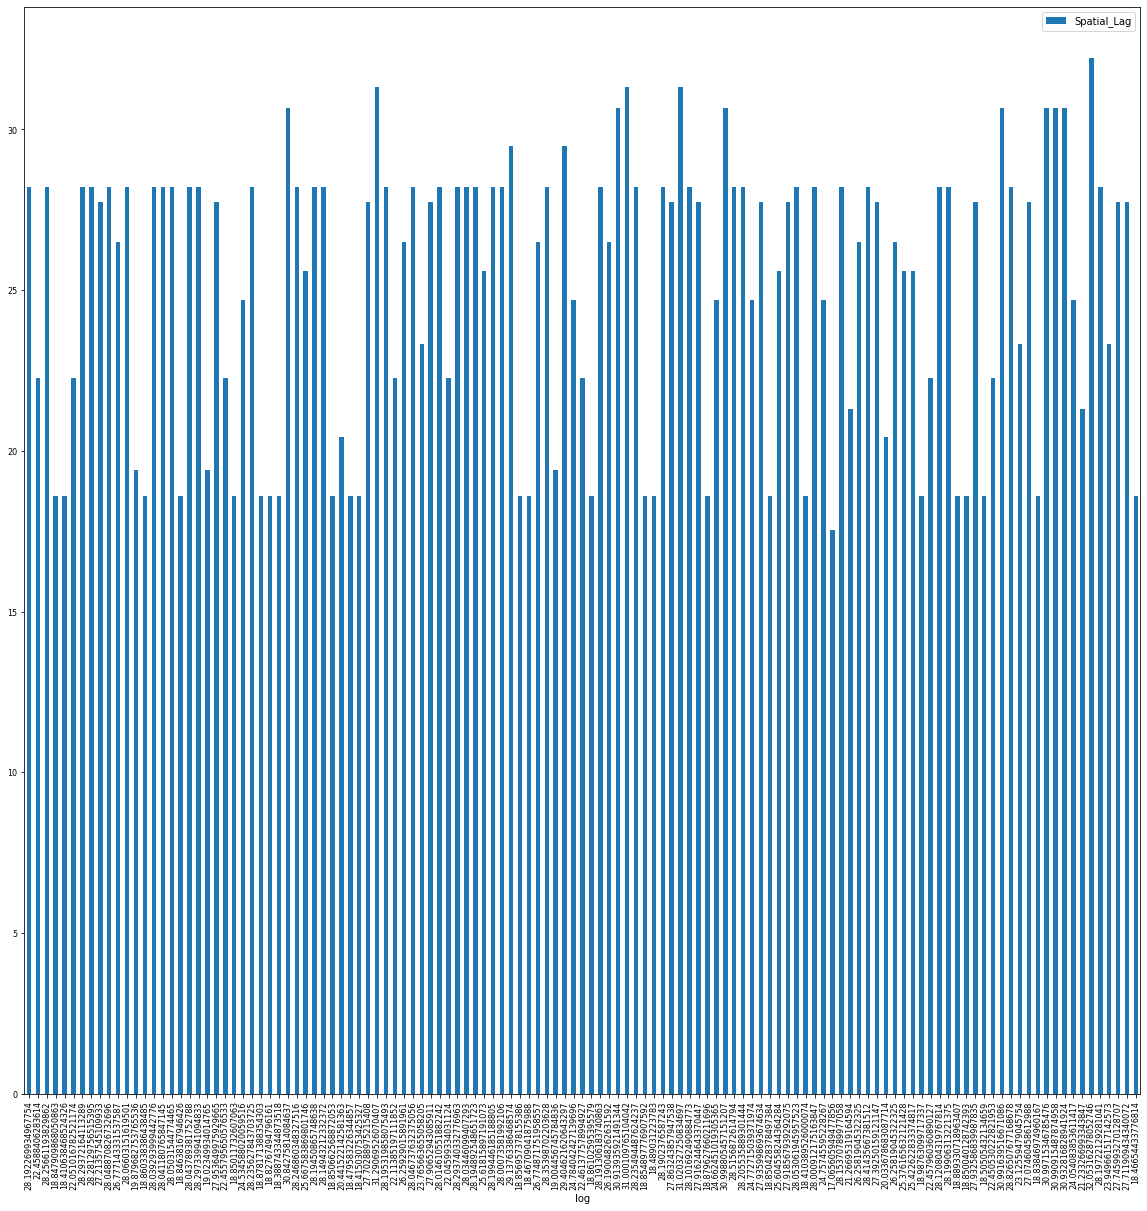

In [17]:
dfD = pd.DataFrame(Dataset)
dfD = dfD.sort_values(dfD.columns[3] , ascending=False)
dfDtr =dfD[:125]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 20]
x=dfDtr[dfDtr.columns[1]]
print(x)
y=dfDtr[dfDtr.columns[2]]
print(y)
print(len(x))
print(len(y))
df = pd.DataFrame({'Spatial_Lag':y,
                   'log':x})
ax = df.plot.bar(x='log', y='Spatial_Lag',fontsize=8, rot=90)
dfDte =dfD[125:]

In [18]:
#Prediction of new buildings
from sklearn import svm
Xtr =np.array(dfDtr[dfDtr.columns[1]]).reshape(125,1)
Xtr1 =np.array(dfDtr[dfDtr.columns[2]]).reshape(125,1)
Xtrain = np.hstack((Xtr,Xtr1))
ytr = np.array(dfDtr[dfDtr.columns[3]]).reshape(125,1)
Xte = np.array(dfDte[dfDte.columns[1]]).reshape(1226,1)
Xte1 = np.array(dfDte[dfDte.columns[2]]).reshape(1226,1)
Xtest = np.hstack((Xte,Xte1))
clf = svm.SVC()
clf.fit(Xtrain, ytr)
yte=clf.predict(Xtest)
yte = np.array(yte).reshape(1226,1)
Train =np.hstack((Xtrain,ytr))
Test = np.hstack((Xtest,yte))
Datasetl = np.vstack((Train,Test))


C:\Users\athaa\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#0000FF', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50', '#FF7F50'

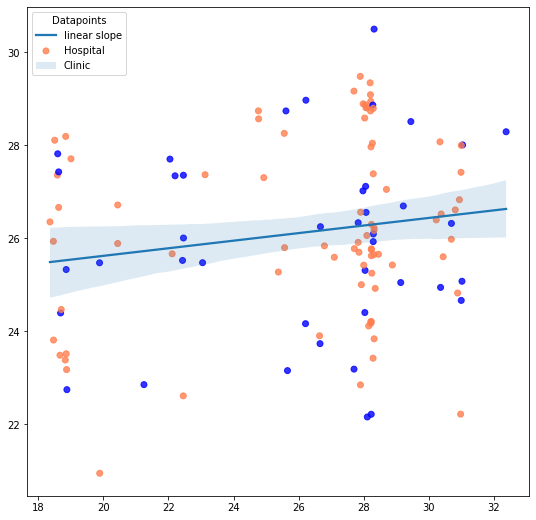

In [19]:
#Plot spatial lag libpysal
xplt = list(p_df['x'])
data = list(dfD[dfD.columns[2]])
#data = data[:121]
xpltb = xplt[:121]
colorizationale=[]
lable=[]
for i in range(0, 121):
    if ytr[i]==1:
        colorization='#FF0000'
        lb='hospital'
    if ytr[i]==2:
        colorization="#0000FF"
        lb='clinic'
    else:
        colorization="#FF7F50"
        lb='dentist'
    colorizationale.append(colorization)
    lable.append(lb)
print(colorizationale)
w = libpysal.weights.lat2W(11,11)
w.transform = "R"
y1 = libpysal.weights.lag_spatial(w,xpltb)
spatial_auto = esda.Moran(y1, w)
print(spatial_auto.I)
#Plot spatial lag manually
import seaborn as sns
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=xpltb, y=y1, data=xpltb, scatter_kws={'color':colorizationale}, label=lable)
plt.legend(title='Datapoints', loc='upper left', labels=['linear slope','Hospital','Clinic','Dentist'])
# Display
plt.show()


In [20]:
namesLoc=[]
colorsl=[]
for i in range(len(Datasetl)):
    if Datasetl[:,2][i]==1:
        color='red'
        namloc='Hospital'
    elif Datasetl[:,2][i]==2:
        color='blue'
        namloc='Clinic'
    elif Datasetl[:,2][i]== 3:
        color='orange'
        namloc='Dentist'
    else:
        value=0
        color='yellow'
    colorsl.append(color)
    namesLoc.append(namloc)
yplt = list(p_df['y'])
yplt=np.array(yplt).reshape(len(yplt),1)
colorsl=np.array(colorsl).reshape(len(colorsl),1)
ycol = np.hstack((yplt,colorsl))
Datasetl=np.hstack((Datasetl,ycol))
df_l= pd.DataFrame(Datasetl, columns=['x','spatial_lag','type','y','color'])
sortx = np.array(p_df['x']).reshape(len(colorsl),1)
colorll=[]
for i in xplt:
    color=colorsl[np.where(sortx == i)]
    colorll.append(str(color[0]))
p_df['CL']= pd.DataFrame(data = colorll , columns=['CL'])
p_df['name']=pd.DataFrame(namesLoc)

In [21]:
#Plot predictions
psourcel = ColumnDataSource(p_df)
msourcee = ColumnDataSource(g_dfi)
sourceel = ColumnDataSource(r_df)
# Create the color mapper
color_mapper = LogColorMapper(palette=palette)
# Initialize our figure
p = figure(title="South-Africa Network")
# Add schools on top (as yellow points)
p.circle('x', 'y', size=3, source=psourcel,
         color='CL', legend_group='name')
p.patches('x', 'y', source=msourcee,
         fill_color={'field': 'Ctel', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.05)
p.multi_line('x', 'y', source=sourceel,
             line_alpha=0.5, line_width=3)
# let's also add the hover over info tool
tooltip = HoverTool()
tooltip.tooltips = [('Healthcare Type', '@healthcare'),
#                    ('Type of road', '@TYYP'),
                    ('Fcode', '@f_code')]
p.add_tools(tooltip)

# Save the figure
outfp = r"data\roads_pop_kmad_asap.html"
output_file(outfp)
show(p)
